In [1]:
# author: "James Haberberger"
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import seaborn as sns
from itertools import combinations
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

In [2]:
adata = ad.AnnData(pd.read_csv('../../figures_and_files/figures_bulk/Microglia.csv').set_index("Unnamed: 0").T)
adata.obs["age"] = [str(x.split("_")[1].split("x")[0]) for x in adata.obs.index]
adata.obs["region"] = [x.split("_")[2] for x in adata.obs.index]
adata.X = csr_matrix(adata.X.astype(float))

In [3]:
adata.layers["raw"] = adata.X.copy()

In [4]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
adata.obsm["X_PCA"] = pca.fit_transform(adata.X.toarray())

In [6]:
adata.obs["PC1"] = adata.obsm["X_PCA"][:, 0]
adata.obs["PC2"] = -adata.obsm["X_PCA"][:, 1]

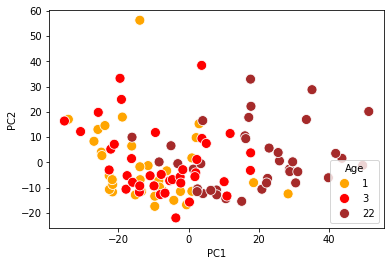

In [7]:
palette = {
    "1": "orange",
    "3": "red",
    "22": "brown"
}
adata.obs["Age"] = adata.obs["age"].astype(float)

sns.scatterplot(data=adata.obs, x="PC1", y="PC2", hue="age", palette=palette, hue_order=["1", "3", "22"], s=100)
plt.legend(title="Age", loc=4)
plt.savefig("Microglia-Age.pdf")

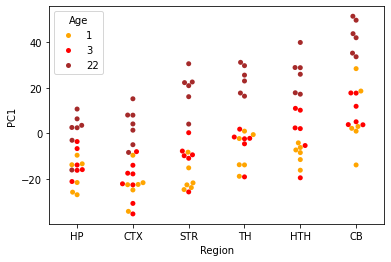

In [8]:
sns.swarmplot(data=adata.obs, x="region", y="PC1", hue="age", palette=palette, hue_order=["1", "3", "22"], order=["HP", "CTX", "STR", "TH", "HTH", "CB"], s=5).set(xlabel="Region", ylabel="PC1")
plt.legend(title="Age")
plt.savefig("Microglia-Region.pdf")

In [9]:
pairs = list(combinations(adata.obs["region"].unique(), 2))
pvals  = [ranksums(adata.obs.loc[adata.obs.region==a, "PC1"],
                  adata.obs.loc[adata.obs.region==b, "PC1"]).pvalue
          for a, b in pairs]
results = pd.DataFrame(
    {"region1": [a for a, _ in pairs],
     "region2": [b for _, b in pairs],
     "pval": pvals,
     "pval_adj": multipletests(pvals, method="fdr_bh")[1]}
)

results

,region1,region2,pval,pval_adj
0,CB,CTX,0.000013,0.000137
1,CB,HP,0.000018,0.000137
2,CB,HTH,0.026781,0.044634
3,CB,STR,0.002148,0.007037
4,CB,TH,0.005366,0.013415
5,CTX,HP,0.249704,0.288120
6,CTX,HTH,0.000980,0.004902
7,CTX,STR,0.158956,0.198695
8,CTX,TH,0.002346,0.007037
9,HP,HTH,0.009798,0.020995
